In [9]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import f1_score
from tqdm import tqdm
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt 

## Кратко о hybrid_gcn_timesformer_pushup

Базовая гибридная модель сочетает графовую сверточную сеть (GCN) для учёта пространственных связей между суставами и архитектуру Timesformer для моделирования временной динамики движения. Модель обрабатывает последовательность скелетных ключевых точек длиной 4 кадра, что обеспечивает оптимальный баланс между детализацией информации и вычислительной производительностью. Благодаря такому комбинированному подходу модель эффективно захватывает как локальные, так и глобальные паттерны движений, что обеспечивает высокую точность классификации отжиманий при умеренном времени обучения.

In [10]:
label_mapping_quality = {
    'false': 0,
    'man_doing_something': 1,
    'true': 2
}
label_mapping_count = {
    'Down': 0,
    'Up': 1
}

In [11]:
def build_adjacency(num_joints: int) -> torch.Tensor:
    """
    Создает нормализованную по строкам матрицу смежности для GCN.
    """
    A = torch.eye(num_joints)
    for i in range(num_joints - 1):
        A[i, i + 1] = 1.0
        A[i + 1, i] = 1.0
    return A / A.sum(dim=1, keepdim=True)

In [12]:
class PushupPoseDatasetFromDF(Dataset):
    """
    Датасет для последовательностей скелетов push-up упражнений.
    Возвращает кортеж (data, quality_label, count_label).
    """
    def __init__(self, df, seq_len, num_joints=17, normalize=True, augment=False):
        self.df = df.reset_index(drop=True)
        self.seq_len = seq_len
        self.num_joints = num_joints
        self.normalize = normalize  # флаг: если True, делаем min–max нормализацию в [0,1]
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        skeleton_path = row['skeleton_file']
        video_path = row['video_path']
        file_name = os.path.basename(video_path)

        # 1. Загружаем последовательность скелета (T, V, 2)
        skeleton_seq = np.load(skeleton_path, allow_pickle=True)
        T, K, C = skeleton_seq.shape

        # 2. Приводим к нужному числу суставов (V = self.num_joints)
        if K != self.num_joints or C != 2:
            if K < self.num_joints:
                pad = np.zeros((T, self.num_joints - K, 2), dtype=skeleton_seq.dtype)
                skeleton_seq = np.concatenate([skeleton_seq, pad], axis=1)
            else:
                skeleton_seq = skeleton_seq[:, :self.num_joints, :2]

        if T < self.seq_len:
            pad_frames = np.zeros((self.seq_len - T, self.num_joints, 2), dtype=skeleton_seq.dtype)
            skeleton_seq = np.concatenate([skeleton_seq, pad_frames], axis=0)
        else:
            skeleton_seq = skeleton_seq[:self.seq_len]

        # 4. Min–Max нормализация к диапазону [0,1]
        if self.normalize:
            # Вычисляем минимум и максимум по всем кадрам и всем суставам, для обеих осей
            min_val = skeleton_seq.min(axis=(0, 1))  
            max_val = skeleton_seq.max(axis=(0, 1)) 
            diff = max_val - min_val
            # Во избежание деления на ноль:
            diff[diff == 0] = 1.0
            # Применяем поэлементно: (x - min)/ (max - min)
            skeleton_seq = (skeleton_seq - min_val) / diff


        data_tensor = torch.tensor(skeleton_seq, dtype=torch.float32)  # (seq_len, V, 2)

        # 6. Метки качества (quality_label) и подсчёта (count_label)
        quality_label_str = row['label']
        quality_label = label_mapping_quality[quality_label_str]

        if quality_label_str == "man_doing_something":
            count_label = 2
        else:
            if 'спуск' in file_name:
                count_label = label_mapping_count['Down']
            elif 'подъем' in file_name:
                count_label = label_mapping_count['Up']
            else:
                count_label = 2

        return data_tensor, quality_label, count_label


In [13]:
gcn_hidden = 64
in_features = 2
num_gcn_layers = 2
d_model = 128
num_classes_quality = 3  # Классы для качества
num_classes_count = 3    # Классы для сгибов рук
num_transformer_layers = 4
nhead = 8
dropout = 0.5
d_angle = 64
seq_len = 4       
num_joints = 17
batch_size = 64
num_epochs = 100
lr = 1e-4
weight_decay = 1e-5

In [14]:
train_csv_path = r"C:\Users\jet\Desktop\видосы\np\2vr_9\skeletons_train\skeleton_records_train.csv"
val_csv_path = r"C:\Users\jet\Desktop\видосы\np\2vr_9\skeletons_val\skeleton_records_val.csv"
train_df = pd.read_csv(train_csv_path)
val_df   = pd.read_csv(val_csv_path)
 
train_dataset = PushupPoseDatasetFromDF(train_df, seq_len=seq_len, num_joints=num_joints, normalize=True)
val_dataset   = PushupPoseDatasetFromDF(val_df, seq_len=seq_len, num_joints=num_joints, normalize=True)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [15]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        """
        Focal Loss для решения проблемы дисбаланса классов.
        :param alpha: Веса классов. Если None, все классы считаются равноважными.
        :param gamma: Фокусирующий параметр. Чем выше gamma, тем больше фокус на сложных примерах.
        :param reduction: Способ агрегации потерь ('none', 'mean', 'sum').
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Применяем логит к целям
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)  # Вероятность предсказания правильного класса
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

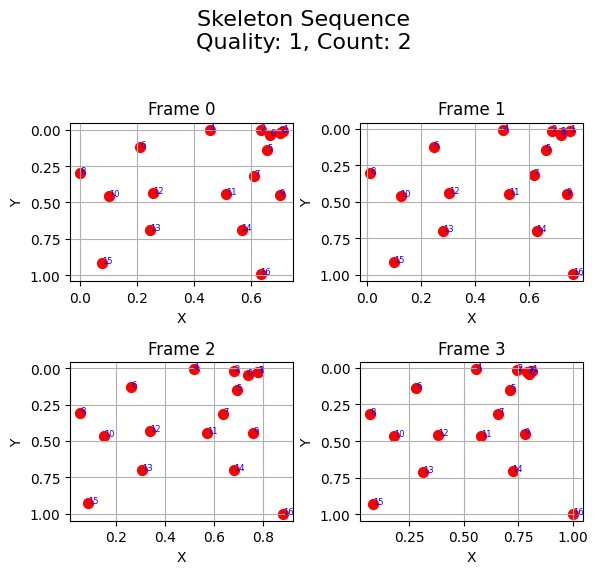

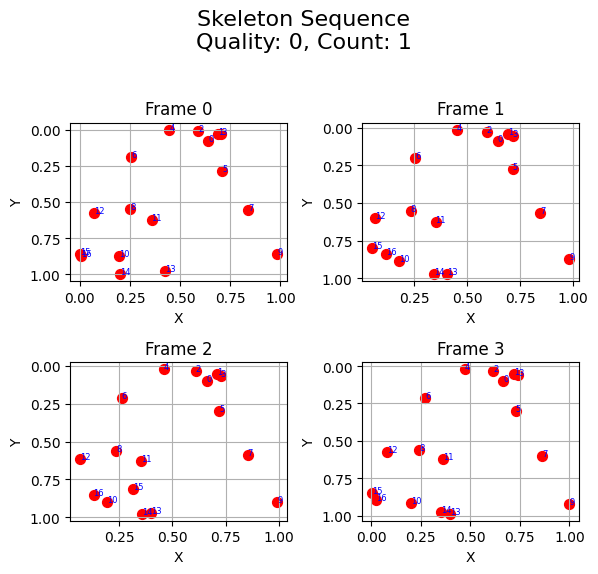

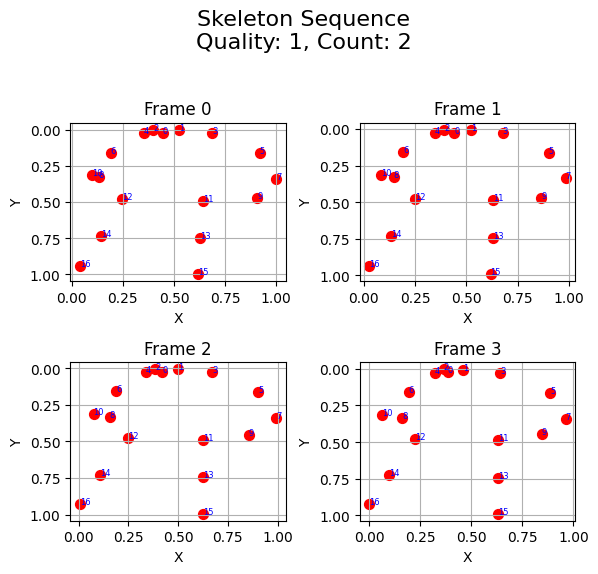

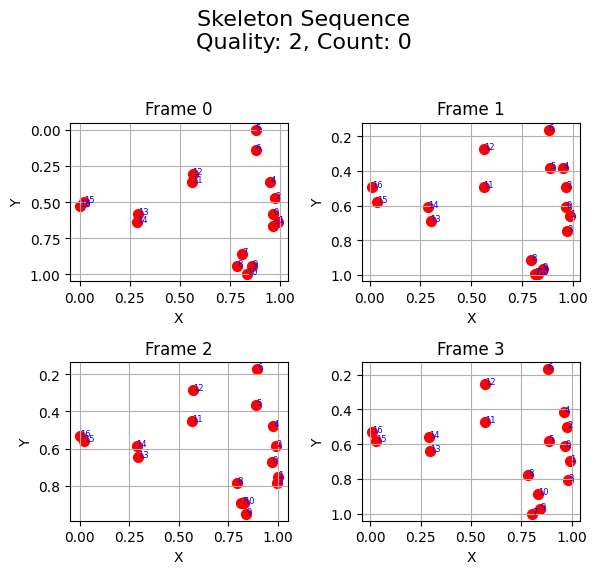

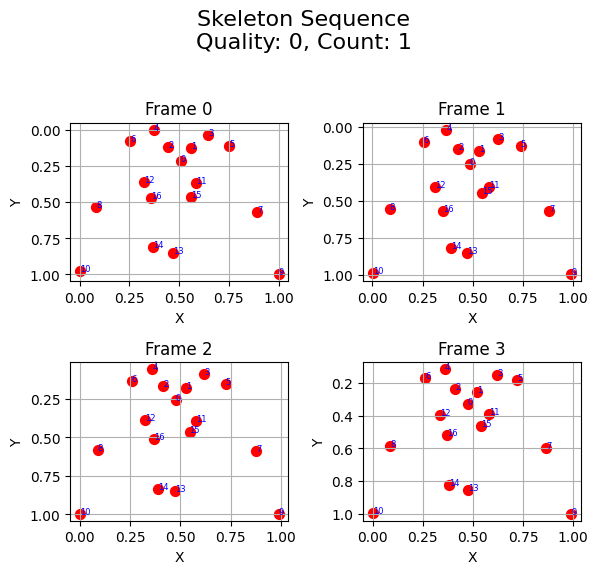

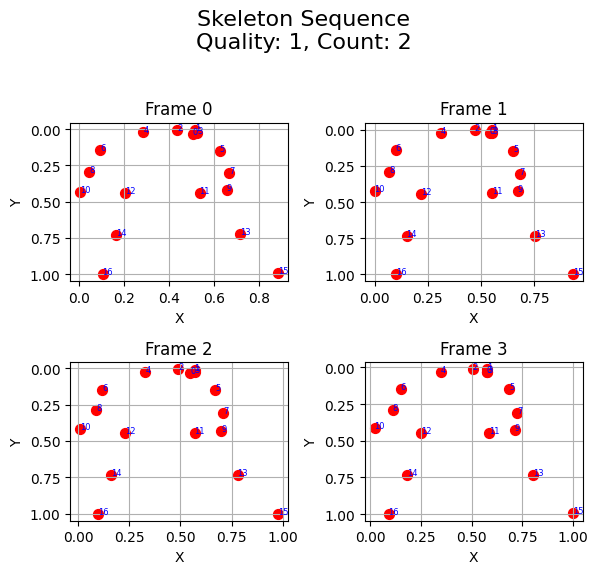

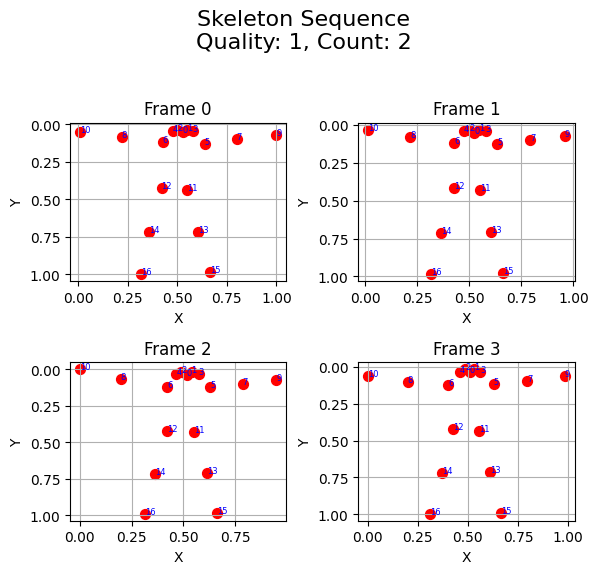

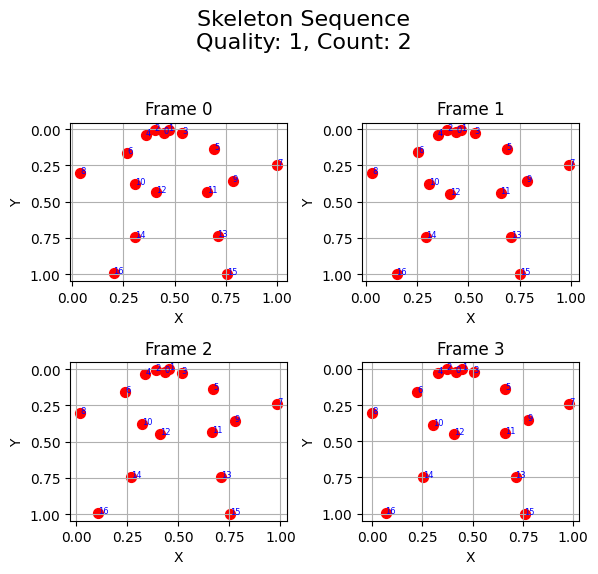

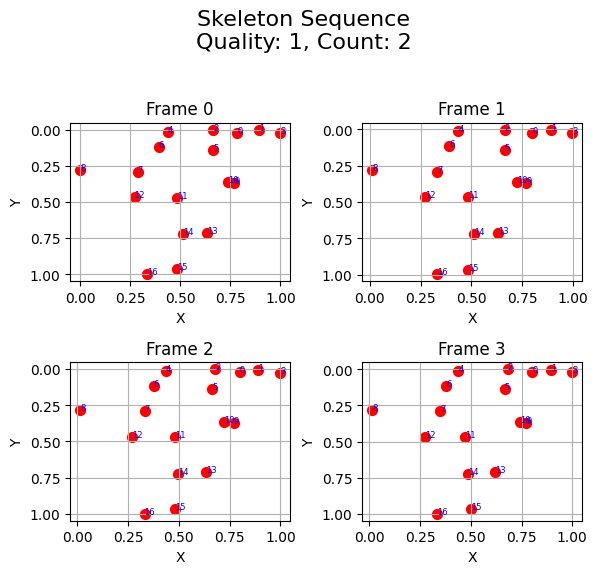

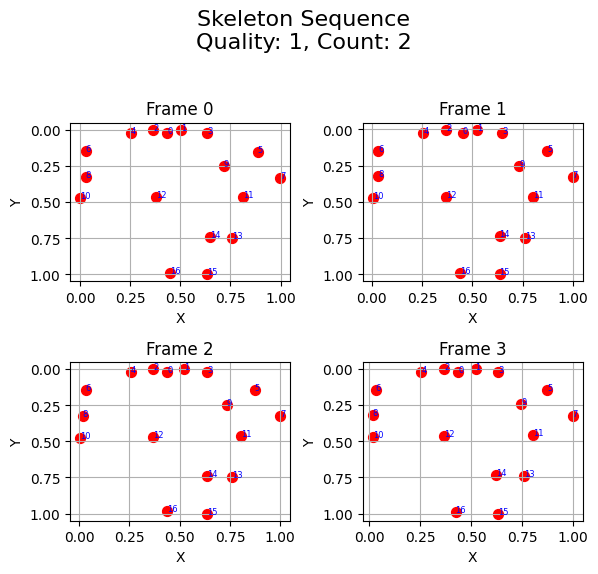

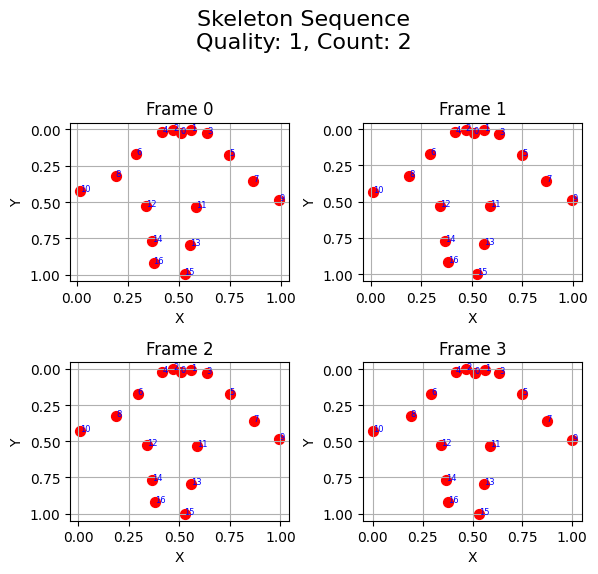

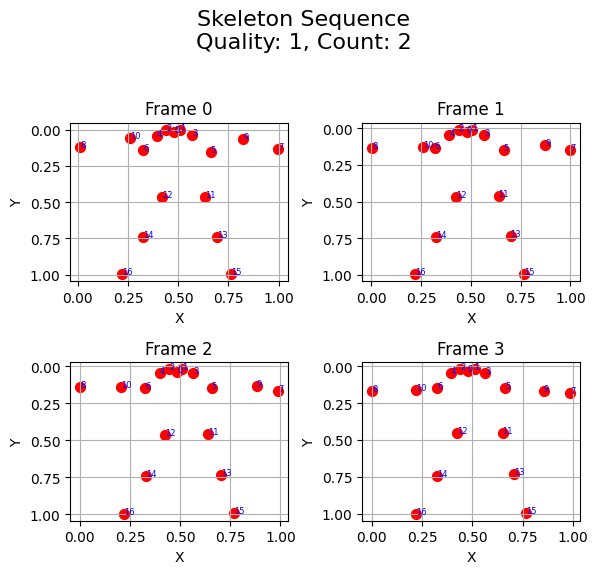

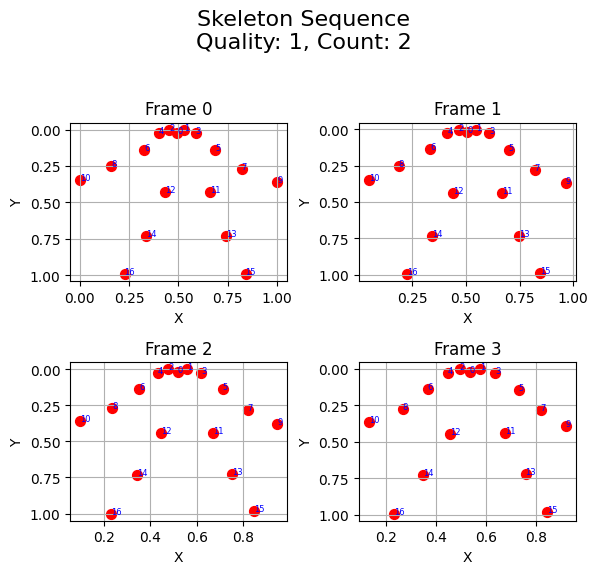

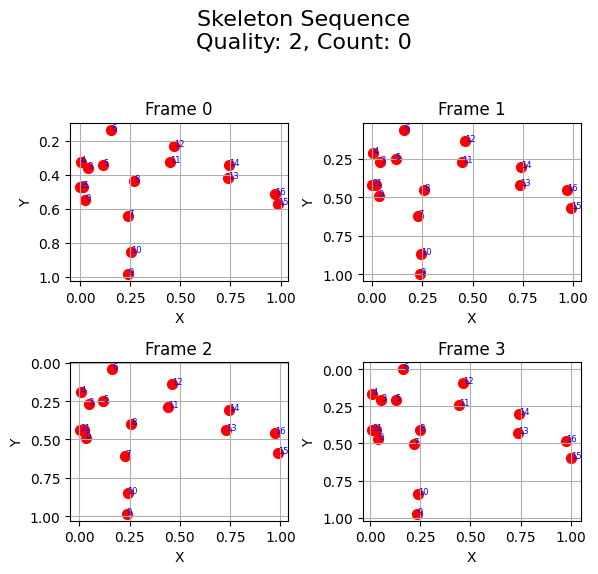

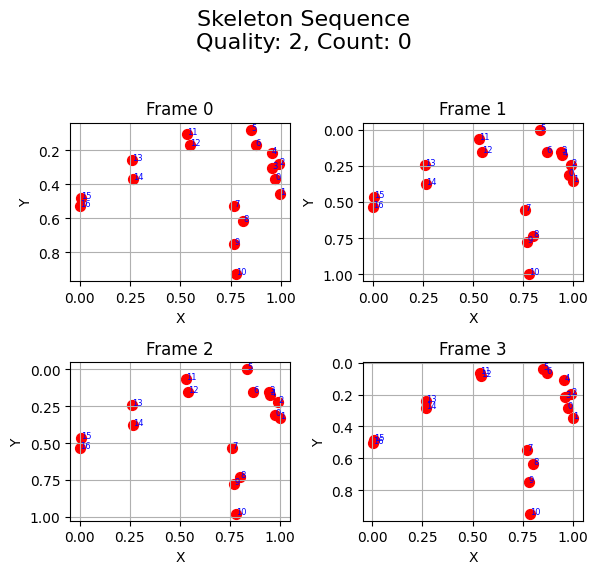

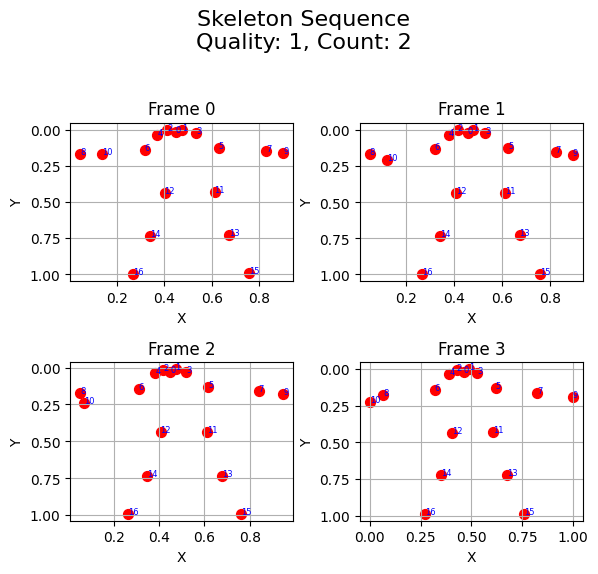

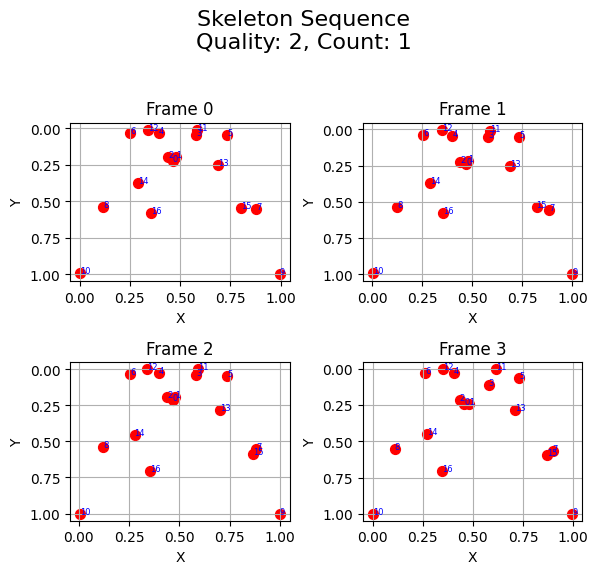

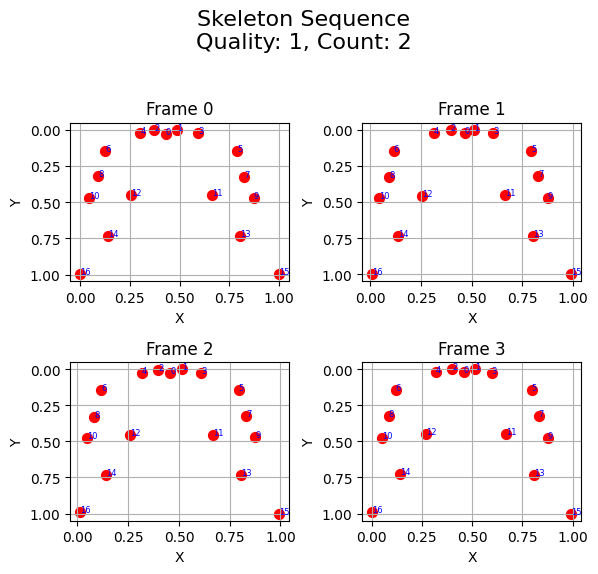

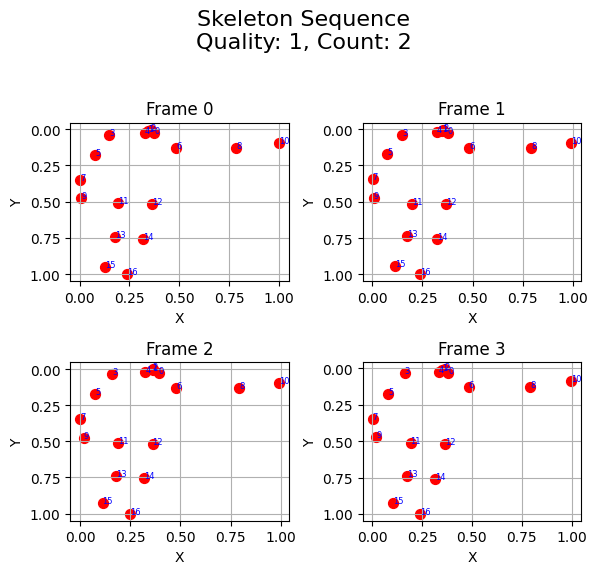

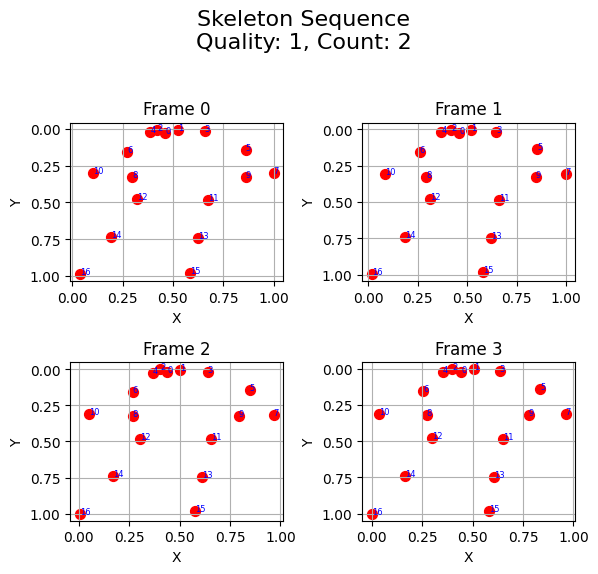

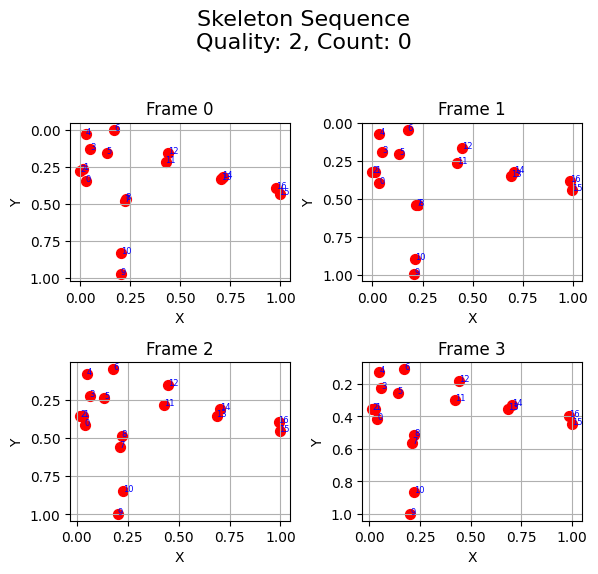

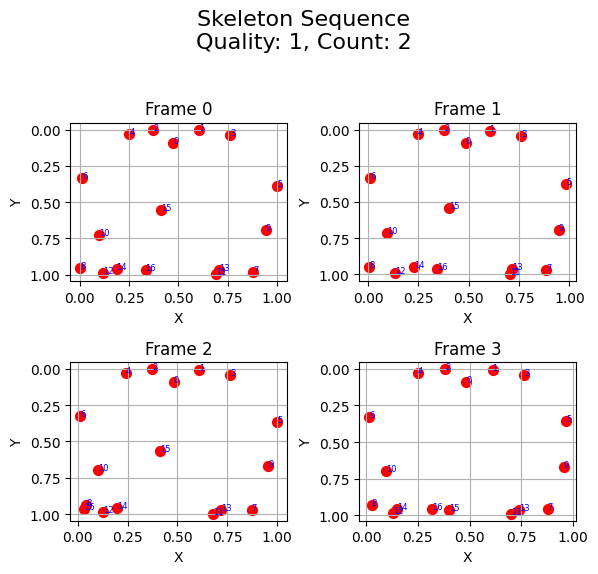

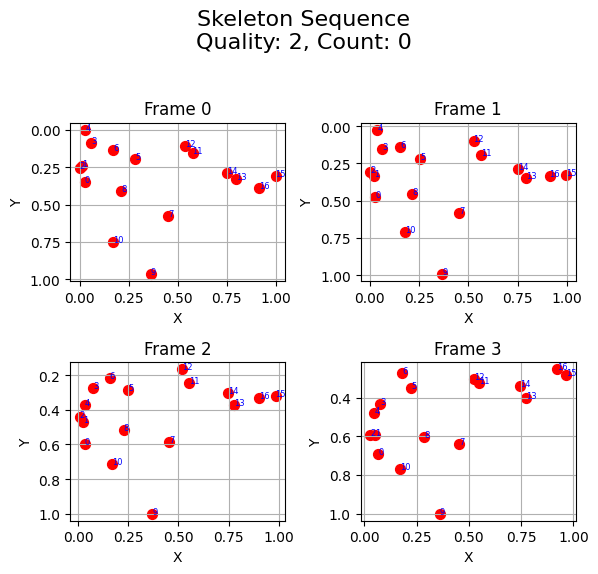

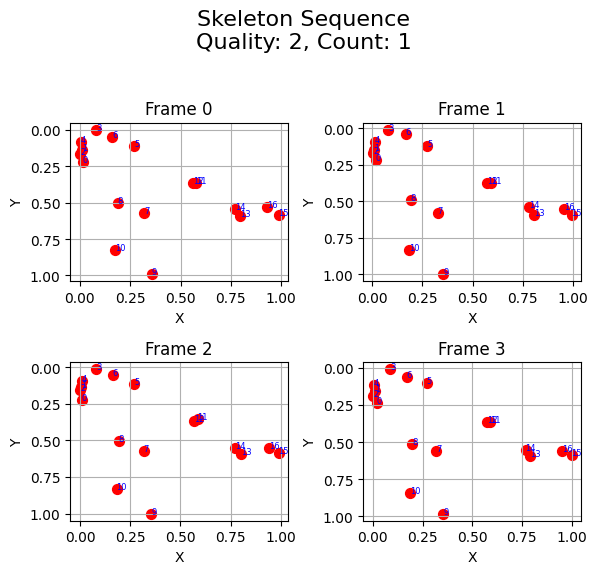

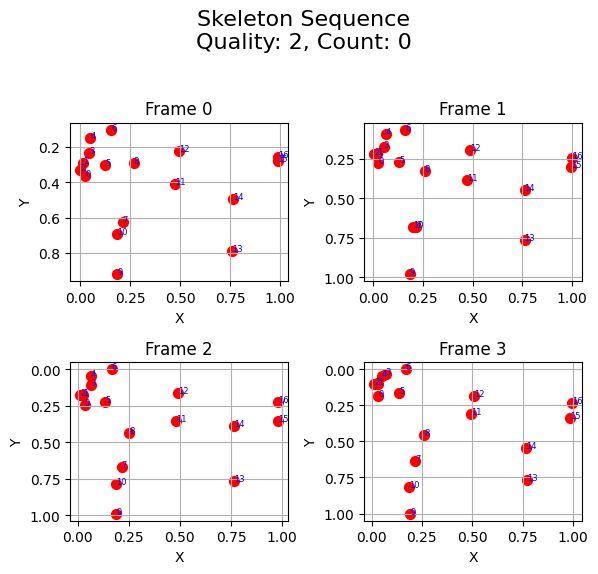

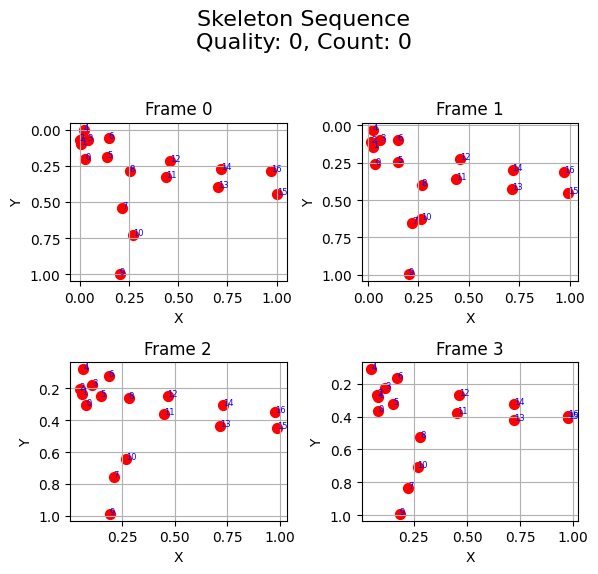

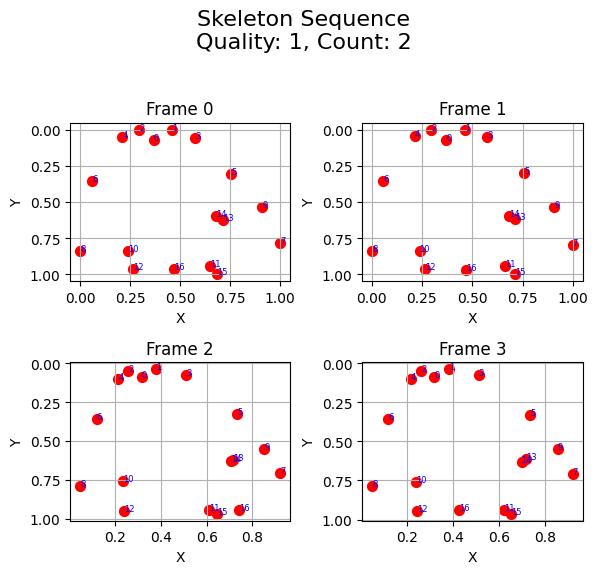

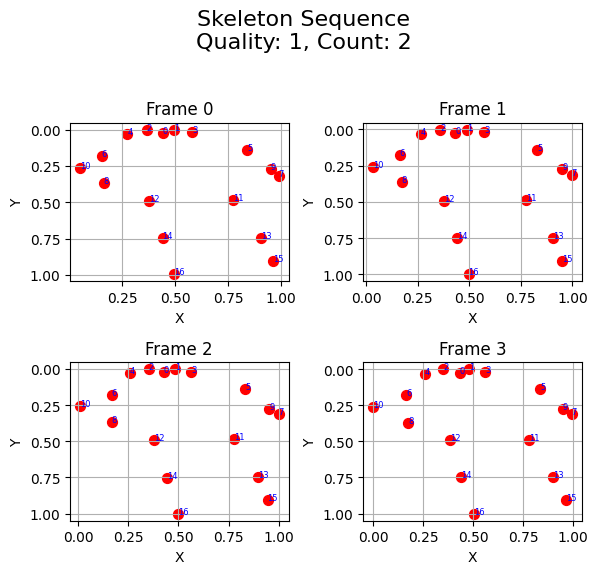

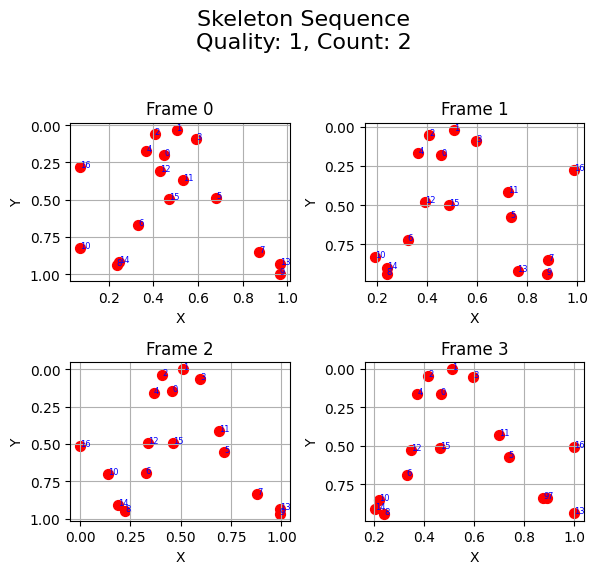


KeyboardInterrupt


KeyboardInterrupt



In [20]:
import matplotlib.pyplot as plt

def visualize_skeleton_sequence(data_tensor, quality_label, count_label):
    """
    Функция для визуализации последовательности скелетных данных.
    
    Аргументы:
      data_tensor: тензор скелетных данных формы (seq_len, num_joints, 2)
      quality_label: метка качества (например, 0, 1, 2)
      count_label: метка сгибов (например, 0, 1 или иное целое число)
      
    Отображается последовательность кадров (например, 16 фреймов) в сетке 4x4.
    """
    # Если data_tensor – тензор Torch, переводим в numpy
    if isinstance(data_tensor, torch.Tensor):
        data_tensor = data_tensor.cpu().numpy()
    
    seq_len = data_tensor.shape[0]
    # Количество строк и столбцов в сетке (например, 4x4 для 16 кадров)
    nrows = int(np.ceil(np.sqrt(seq_len)))
    ncols = nrows

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
    axs = axs.flatten()  # превращаем в одномерный список для удобства

    for i in range(seq_len):
        frame = data_tensor[i]  
        ax = axs[i]
        ax.scatter(frame[:, 0], frame[:, 1], c='red', s=50)
        for j, (x, y) in enumerate(frame):
            ax.text(x, y, f"{j}", fontsize=6, color="blue")
        ax.set_title(f"Frame {i}")
        ax.invert_yaxis()  # если нужно инвертировать ось Y
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.grid(True)

    # Если осталось лишние subplots, скрываем их:
    for i in range(seq_len, len(axs)):
        axs[i].axis('off')

    plt.suptitle(f"Skeleton Sequence\nQuality: {quality_label}, Count: {count_label}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Пример: возьмём первый батч и визуализируем первые N примеров из него
batch_data, batch_quality, batch_count = next(iter(train_loader))

N = min(100, batch_data.size(0))   
for i in range(N):
    data_tensor = batch_data[i]         
    quality_label = batch_quality[i].item()
    count_label = batch_count[i].item()
    visualize_skeleton_sequence(data_tensor, quality_label, count_label)

In [16]:
class RandomJointDropout(nn.Module):
    def __init__(self, p: float = 0.1):
        """
        p — вероятность обнуления каждого сустава.
        """
        super().__init__()
        self.p = p

    def forward(self, x):
        # x: (B, T, V, 2)
        if not self.training or self.p == 0.0:
            return x
        B, T, V, C = x.shape
        # Для каждого примера и каждого сустава решаем: обнулять ли его?
        # mask: True = keep, False = zero
        mask = (torch.rand(B, V, device=x.device) > self.p) \
               .float() \
               .view(B, 1, V, 1)  # (B,1,V,1)
        return x * mask  # broadcasting по временной и координатной осям

## Различия между hybrid_gcn_timesformer_pushup и hybrid_gcn_timesformer_pushup_joint_dropout

В экспериментах модель с RandomJointDropout демонстрировала прирост метрик на 5–6% по сравнению с базовой гибридной архитектурой.

hybrid_gcn_timesformer_pushup.ipynb: базовая гибридная архитектура GCN + Timesformer для классификации отжиманий без регуляризации.

hybrid_gcn_timesformer_pushup_joint_dropout.ipynb: добавляет слой RandomJointDropout, который во время обучения с вероятностью p обнуляет отдельные суставы (по оси V) в тензоре входных данных (B, T, V, C), что повышает устойчивость модели к шуму и снижает переобучение.

In [17]:
# ===================== Функция для вычисления углов =====================
def compute_angles(x):
    """
    Вычисляет геометрические признаки (углы) для каждого кадра.
    x: тензор формы (batch, seq_len, num_joints, 2)
    Возвращает тензор размера (batch, seq_len, 3)
    """

    
    l_shoulder, l_elbow, l_wrist = 5, 7, 9
    
    r_shoulder, r_elbow, r_wrist = 6, 8, 10
    
    l_hip, r_hip = 11, 12

    def angle(a, b, c):
        ba = a - b
        bc = c - b
        dot = (ba * bc).sum(dim=-1)
        cos = dot / (torch.norm(ba, dim=-1) * torch.norm(bc, dim=-1) + 1e-8)
        cos = cos.clamp(-1.0, 1.0)
        return torch.acos(cos) * 180.0 / np.pi

    a1 = x[..., l_shoulder, :]
    b1 = x[..., l_elbow, :]
    c1 = x[..., l_wrist, :]
    a2 = x[..., r_shoulder, :]
    b2 = x[..., r_elbow, :]
    c2 = x[..., r_wrist, :]
    angle1 = angle(a1, b1, c1)
    angle2 = angle(a2, b2, c2)

    mid_sh = (x[..., l_shoulder, :] + x[..., r_shoulder, :]) / 2
    mid_hp = (x[..., l_hip, :] + x[..., r_hip, :]) / 2
    torso = mid_hp - mid_sh
    horiz = torch.tensor([1.0, 0.0], device=x.device).view(1,1,2).expand_as(torso)
    dot_t = (torso * horiz).sum(dim=-1)
    cos_t = (dot_t / (torch.norm(torso, dim=-1) + 1e-8)).clamp(-1.0,1.0)
    torso_ang = torch.acos(cos_t) * 180.0 / np.pi

    return torch.stack([angle1, angle2, torso_ang], dim=-1)

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features, num_joints, bias=True):
        super().__init__()
        # Обучаемая матрица смежности
        self.A = nn.Parameter(torch.eye(num_joints), requires_grad=True)
        # Основной линейный слой
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        # Проекция для резидуального подключения
        self.skip = nn.Linear(in_features, out_features, bias=False)
        self.dropout = nn.Dropout(0.2)
        # BatchNorm по фичам (out_features)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x, _=None):
        # x: (N, V, F_in)
        # Нормализуем A по строкам
        A = self.A / (self.A.sum(dim=1, keepdim=True) + 1e-6)

        # Основное GCN-обновление
        out = torch.matmul(A, x)           # (N, V, F_in)
        out = self.linear(out)             # (N, V, F_out)

        # Резидуальное соединение
        skip = self.skip(x)                # (N, V, F_out)
        out = out + skip                   # (N, V, F_out)

        # Нормализация, дропаут и активация
        out = self.bn(out.transpose(1,2)).transpose(1,2)  # BatchNorm по каналам
        out = F.relu(self.dropout(out))
        return out

# ===================== Модель Hybrid GCN + TimeSFormer =====================
class HybridGCNTimeSFormerMultiTask(nn.Module):
    def __init__(self, num_joints, in_features, gcn_hidden, num_gcn_layers,
                 d_model, seq_len, num_classes_quality, num_classes_count,
                 num_transformer_layers, nhead, dropout=0.1, d_angle=64,joint_dropout_p=0.3):
        super().__init__()
        self.num_joints = num_joints

        self.joint_dropout = RandomJointDropout(p=joint_dropout_p)
        # GCN-блок
        layers = [GCNLayer(in_features, gcn_hidden, num_joints)]
        for _ in range(num_gcn_layers-1):
            layers.append(GCNLayer(gcn_hidden, gcn_hidden, num_joints))
        self.gcn_layers = nn.ModuleList(layers)
        # Линейное преобразование GCN-выходов
        self.embedding = nn.Linear(num_joints * gcn_hidden, d_model)
        # Transformer
        self.cls_token = nn.Parameter(torch.zeros(1,1,d_model))
        self.pos_emb   = nn.Parameter(torch.zeros(1, seq_len+1, d_model))
        self.dropout   = nn.Dropout(dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        # MLP для углов
        self.angle_mlp = nn.Sequential(
            nn.Linear(3, d_angle), nn.ReLU(), nn.Linear(d_angle, d_angle)
        )
        # Головы классификации
        self.head_quality = nn.Sequential(
            nn.LayerNorm(d_model + d_angle),
            nn.Linear(d_model + d_angle, num_classes_quality)
        )
        self.head_count   = nn.Sequential(
            nn.LayerNorm(d_model + d_angle),
            nn.Linear(d_model + d_angle, num_classes_count)
        )

    def forward(self, x, A=None):
        x = self.joint_dropout(x)
        B, T, V, F = x.size()
        # Векторизованный GCN по кадрам
        frames = x.view(B*T, V, F)          # (B*T, V, F)
        for layer in self.gcn_layers:
            frames = layer(frames)
        # reshape вместо view для поддержки неконтiguous тензоров
        gcn_out = frames.reshape(B, T, V * self.gcn_layers[-1].linear.out_features)
        # Transformer
        x_emb = self.embedding(gcn_out)     # (B, T, d_model)
        cls   = self.cls_token.expand(B, -1, -1)
        seq   = torch.cat([cls, x_emb], dim=1) + self.pos_emb
        seq   = self.dropout(seq)
        tr_out= self.transformer(seq)
        cls_out = tr_out[:,0]
        # Угловые признаки
        angles  = compute_angles(x)         # (B, T, 3)
        ang_avg = angles.mean(dim=1)        # (B, 3)
        ang_emb = self.angle_mlp(ang_avg)   # (B, d_angle)
        # Объединяем и классифицируем
        comb = torch.cat([cls_out, ang_emb], dim=1)
        # Возвращаем логиты качества и количества сгибов
        return self.head_quality(comb), self.head_count(comb)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HybridGCNTimeSFormerMultiTask(
    num_joints, 2, 64, 2, 128, seq_len, 3, 3, 4, nhead,dropout, 64
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = FocalLoss()
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
A = build_adjacency(num_joints).to(device)


In [19]:
def validate(model, loader, A, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    correct_quality = 0
    correct_count = 0
    all_true_quality = []
    all_pred_quality = []
    with torch.no_grad():
        for data, label_quality, label_count in tqdm(loader, desc="Validation", leave=False):
            data = data.to(device)
            label_quality = label_quality.to(device)
            label_count = label_count.to(device)
            logits_quality, logits_count = model(data, A)
            loss_quality = criterion(logits_quality, label_quality)
            loss_count = criterion(logits_count, label_count)
            loss = loss_quality + loss_count
            total_loss += loss.item() * data.size(0)
            total_samples += data.size(0)
            _, pred_quality = torch.max(logits_quality, dim=1)
            _, pred_count = torch.max(logits_count, dim=1)
            correct_quality += (pred_quality == label_quality).sum().item()
            correct_count += (pred_count == label_count).sum().item()
            all_true_quality.extend(label_quality.cpu().numpy().tolist())
            all_pred_quality.extend(pred_quality.cpu().numpy().tolist())
    avg_loss = total_loss / total_samples
    acc_quality = correct_quality / total_samples
    acc_count = correct_count / total_samples
    # Для класса "true" (label=2) вычисляем F1
    binary_true = [1 if x == 2 else 0 for x in all_true_quality]
    binary_pred = [1 if x == 2 else 0 for x in all_pred_quality]
    f1_true = f1_score(binary_true, binary_pred, average='binary')
    overall_f1 = f1_score(all_true_quality, all_pred_quality, average='macro')
    return avg_loss, acc_quality, acc_count, f1_true, overall_f1

In [19]:
best_val_overall_f1 = 0.0  # переменная для хранения лучшего показателя Overall F1

mlflow.set_experiment("HybridGCNTimeSFormer_MultiTask_3")
with mlflow.start_run():
    mlflow.log_param("seq_len", seq_len)
    mlflow.log_param("num_joints", num_joints)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("gcn_hidden", gcn_hidden)
    mlflow.log_param("num_gcn_layers", num_gcn_layers)
    mlflow.log_param("d_model", d_model)
    mlflow.log_param("num_classes_quality", num_classes_quality)
    mlflow.log_param("num_classes_count", num_classes_count)
    mlflow.log_param("num_transformer_layers", num_transformer_layers)
    mlflow.log_param("nhead", nhead)
    mlflow.log_param("dropout", dropout)
    mlflow.log_param("d_angle", d_angle)
    mlflow.log_param("learning_rate", 1e-4)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False)
        for data, label_quality, label_count in train_bar:
            data = data.to(device)
            label_quality = label_quality.to(device)
            label_count = label_count.to(device)
            optimizer.zero_grad()
            logits_quality, logits_count = model(data, A)
            loss_quality = criterion(logits_quality, label_quality)
            loss_count = criterion(logits_count, label_count)
            loss = loss_quality + loss_count
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)
            train_bar.set_postfix(loss=loss.item())
        
        epoch_loss = running_loss / len(train_dataset)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f}")
        
        val_loss, val_acc_quality, val_acc_count, val_f1_true, val_overall_f1 = validate(model, val_loader, A, device)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Quality Acc: {val_acc_quality:.4f} | Count Acc: {val_acc_count:.4f} | "
              f"Val F1 for true: {val_f1_true:.4f} | Overall F1 (quality): {val_overall_f1:.4f}")
        
        mlflow.log_metric("Train Loss", epoch_loss, step=epoch)
        mlflow.log_metric("Val Loss", val_loss, step=epoch)
        mlflow.log_metric("Quality Accuracy", val_acc_quality, step=epoch)
        mlflow.log_metric("Count Accuracy", val_acc_count, step=epoch)
        mlflow.log_metric("Val_F1_for_true", val_f1_true, step=epoch)
        mlflow.log_metric("Overall_Quality_F1", val_overall_f1, step=epoch)
        
        # Сохраняем модель, если улучшился показатель Overall F1
        if val_f1_true > best_val_overall_f1:
            best_val_overall_f1 = val_f1_true
            best_model_path = "best_model_2_0_3_6_drop.pth"
            torch.save(model.state_dict(), best_model_path)
            mlflow.log_artifact(best_model_path, artifact_path="models")
            print(f"Epoch {epoch+1}: New best Overall Quality F1: {best_val_overall_f1:.4f}. Model saved.")
    
    mlflow.pytorch.log_model(model, "final_model")

Epoch 1/100 | Train Loss: 0.4278


Epoch 1/100 | Train Loss: 0.4278 | Val Loss: 0.2675 | Quality Acc: 0.7515 | Count Acc: 0.8954 | Val F1 for true: 0.6806 | Overall F1 (quality): 0.7371
Epoch 1: New best Overall Quality F1: 0.6806. Model saved.


Epoch 2/100 | Train Loss: 0.2791


Epoch 2/100 | Train Loss: 0.2791 | Val Loss: 0.2054 | Quality Acc: 0.8645 | Count Acc: 0.9507 | Val F1 for true: 0.8486 | Overall F1 (quality): 0.8455
Epoch 2: New best Overall Quality F1: 0.8486. Model saved.


Epoch 3/100 | Train Loss: 0.2577


Epoch 3/100 | Train Loss: 0.2577 | Val Loss: 0.2007 | Quality Acc: 0.8308 | Count Acc: 0.9495 | Val F1 for true: 0.8193 | Overall F1 (quality): 0.7964


Epoch 4/100 | Train Loss: 0.2467


Epoch 4/100 | Train Loss: 0.2467 | Val Loss: 0.1927 | Quality Acc: 0.8777 | Count Acc: 0.9165 | Val F1 for true: 0.8644 | Overall F1 (quality): 0.8625
Epoch 4: New best Overall Quality F1: 0.8644. Model saved.


Epoch 5/100 | Train Loss: 0.2365


Epoch 5/100 | Train Loss: 0.2365 | Val Loss: 0.1945 | Quality Acc: 0.8756 | Count Acc: 0.9459 | Val F1 for true: 0.8656 | Overall F1 (quality): 0.8589
Epoch 5: New best Overall Quality F1: 0.8656. Model saved.


Epoch 6/100 | Train Loss: 0.2304


Epoch 6/100 | Train Loss: 0.2304 | Val Loss: 0.1806 | Quality Acc: 0.8585 | Count Acc: 0.9480 | Val F1 for true: 0.8483 | Overall F1 (quality): 0.8336


Epoch 7/100 | Train Loss: 0.2267


Epoch 7/100 | Train Loss: 0.2267 | Val Loss: 0.1783 | Quality Acc: 0.8386 | Count Acc: 0.9216 | Val F1 for true: 0.8309 | Overall F1 (quality): 0.8042


Epoch 8/100 | Train Loss: 0.2154


Epoch 8/100 | Train Loss: 0.2154 | Val Loss: 0.1653 | Quality Acc: 0.8540 | Count Acc: 0.9543 | Val F1 for true: 0.8395 | Overall F1 (quality): 0.8315


Epoch 9/100 | Train Loss: 0.2116


Epoch 9/100 | Train Loss: 0.2116 | Val Loss: 0.1873 | Quality Acc: 0.8128 | Count Acc: 0.9513 | Val F1 for true: 0.8053 | Overall F1 (quality): 0.7674


Epoch 10/100 | Train Loss: 0.2071


Epoch 10/100 | Train Loss: 0.2071 | Val Loss: 0.1924 | Quality Acc: 0.8029 | Count Acc: 0.9558 | Val F1 for true: 0.7999 | Overall F1 (quality): 0.7472


Epoch 11/100 | Train Loss: 0.2018


Epoch 11/100 | Train Loss: 0.2018 | Val Loss: 0.1685 | Quality Acc: 0.8278 | Count Acc: 0.9570 | Val F1 for true: 0.8075 | Overall F1 (quality): 0.8035


Epoch 12/100 | Train Loss: 0.1982


Epoch 12/100 | Train Loss: 0.1982 | Val Loss: 0.1792 | Quality Acc: 0.8398 | Count Acc: 0.9621 | Val F1 for true: 0.8329 | Overall F1 (quality): 0.8085


Epoch 13/100 | Train Loss: 0.1932


Epoch 13/100 | Train Loss: 0.1932 | Val Loss: 0.1642 | Quality Acc: 0.8504 | Count Acc: 0.9564 | Val F1 for true: 0.8390 | Overall F1 (quality): 0.8266


Epoch 14/100 | Train Loss: 0.1875


Epoch 14/100 | Train Loss: 0.1875 | Val Loss: 0.1705 | Quality Acc: 0.8483 | Count Acc: 0.9567 | Val F1 for true: 0.8401 | Overall F1 (quality): 0.8223


Epoch 15/100 | Train Loss: 0.1859


Epoch 15/100 | Train Loss: 0.1859 | Val Loss: 0.1610 | Quality Acc: 0.8675 | Count Acc: 0.9555 | Val F1 for true: 0.8520 | Overall F1 (quality): 0.8519


Epoch 16/100 | Train Loss: 0.1825


Epoch 16/100 | Train Loss: 0.1825 | Val Loss: 0.1549 | Quality Acc: 0.8633 | Count Acc: 0.9576 | Val F1 for true: 0.8398 | Overall F1 (quality): 0.8515


Epoch 17/100 | Train Loss: 0.1770


Epoch 17/100 | Train Loss: 0.1770 | Val Loss: 0.1664 | Quality Acc: 0.8645 | Count Acc: 0.9480 | Val F1 for true: 0.8690 | Overall F1 (quality): 0.8425
Epoch 17: New best Overall Quality F1: 0.8690. Model saved.


Epoch 18/100 | Train Loss: 0.1708


Epoch 18/100 | Train Loss: 0.1708 | Val Loss: 0.1594 | Quality Acc: 0.8822 | Count Acc: 0.9417 | Val F1 for true: 0.8726 | Overall F1 (quality): 0.8694
Epoch 18: New best Overall Quality F1: 0.8726. Model saved.


Epoch 19/100 | Train Loss: 0.1697


Epoch 19/100 | Train Loss: 0.1697 | Val Loss: 0.1407 | Quality Acc: 0.8717 | Count Acc: 0.9606 | Val F1 for true: 0.8656 | Overall F1 (quality): 0.8525


Epoch 20/100 | Train Loss: 0.1667


Epoch 20/100 | Train Loss: 0.1667 | Val Loss: 0.1576 | Quality Acc: 0.9162 | Count Acc: 0.9501 | Val F1 for true: 0.9073 | Overall F1 (quality): 0.9116
Epoch 20: New best Overall Quality F1: 0.9073. Model saved.


Epoch 21/100 | Train Loss: 0.1637


Epoch 21/100 | Train Loss: 0.1637 | Val Loss: 0.1726 | Quality Acc: 0.8597 | Count Acc: 0.9420 | Val F1 for true: 0.8676 | Overall F1 (quality): 0.8352


Epoch 22/100 | Train Loss: 0.1593


Epoch 22/100 | Train Loss: 0.1593 | Val Loss: 0.1635 | Quality Acc: 0.8753 | Count Acc: 0.9582 | Val F1 for true: 0.8703 | Overall F1 (quality): 0.8620


Epoch 23/100 | Train Loss: 0.1612


Epoch 23/100 | Train Loss: 0.1612 | Val Loss: 0.1415 | Quality Acc: 0.8885 | Count Acc: 0.9666 | Val F1 for true: 0.8820 | Overall F1 (quality): 0.8751


Epoch 24/100 | Train Loss: 0.1552


Epoch 24/100 | Train Loss: 0.1552 | Val Loss: 0.1441 | Quality Acc: 0.8771 | Count Acc: 0.9621 | Val F1 for true: 0.8875 | Overall F1 (quality): 0.8557


Epoch 25/100 | Train Loss: 0.1541


Epoch 25/100 | Train Loss: 0.1541 | Val Loss: 0.1536 | Quality Acc: 0.8804 | Count Acc: 0.9669 | Val F1 for true: 0.8790 | Overall F1 (quality): 0.8622


Epoch 26/100 | Train Loss: 0.1492


Epoch 26/100 | Train Loss: 0.1492 | Val Loss: 0.1458 | Quality Acc: 0.8849 | Count Acc: 0.9651 | Val F1 for true: 0.8826 | Overall F1 (quality): 0.8693


Epoch 27/100 | Train Loss: 0.1472


Epoch 27/100 | Train Loss: 0.1472 | Val Loss: 0.1536 | Quality Acc: 0.8762 | Count Acc: 0.9582 | Val F1 for true: 0.8805 | Overall F1 (quality): 0.8576


Epoch 28/100 | Train Loss: 0.1463


Epoch 28/100 | Train Loss: 0.1463 | Val Loss: 0.1518 | Quality Acc: 0.8804 | Count Acc: 0.9678 | Val F1 for true: 0.8774 | Overall F1 (quality): 0.8632


Epoch 29/100 | Train Loss: 0.1470


Epoch 29/100 | Train Loss: 0.1470 | Val Loss: 0.1641 | Quality Acc: 0.8708 | Count Acc: 0.9663 | Val F1 for true: 0.8772 | Overall F1 (quality): 0.8512


Epoch 30/100 | Train Loss: 0.1441


Epoch 30/100 | Train Loss: 0.1441 | Val Loss: 0.1531 | Quality Acc: 0.8837 | Count Acc: 0.9688 | Val F1 for true: 0.8805 | Overall F1 (quality): 0.8684


Epoch 31/100 | Train Loss: 0.1399


Epoch 31/100 | Train Loss: 0.1399 | Val Loss: 0.1516 | Quality Acc: 0.8615 | Count Acc: 0.9691 | Val F1 for true: 0.8649 | Overall F1 (quality): 0.8432


Epoch 32/100 | Train Loss: 0.1405


Epoch 32/100 | Train Loss: 0.1405 | Val Loss: 0.1837 | Quality Acc: 0.8459 | Count Acc: 0.9546 | Val F1 for true: 0.8535 | Overall F1 (quality): 0.8266


Epoch 33/100 | Train Loss: 0.1400


Epoch 33/100 | Train Loss: 0.1400 | Val Loss: 0.1388 | Quality Acc: 0.8711 | Count Acc: 0.9642 | Val F1 for true: 0.8724 | Overall F1 (quality): 0.8536


Epoch 34/100 | Train Loss: 0.1369


Epoch 34/100 | Train Loss: 0.1369 | Val Loss: 0.1869 | Quality Acc: 0.8645 | Count Acc: 0.9198 | Val F1 for true: 0.8805 | Overall F1 (quality): 0.8430


Epoch 35/100 | Train Loss: 0.1370


Epoch 35/100 | Train Loss: 0.1370 | Val Loss: 0.1431 | Quality Acc: 0.8666 | Count Acc: 0.9688 | Val F1 for true: 0.8580 | Overall F1 (quality): 0.8507


Epoch 36/100 | Train Loss: 0.1320


Epoch 36/100 | Train Loss: 0.1320 | Val Loss: 0.1378 | Quality Acc: 0.8609 | Count Acc: 0.9660 | Val F1 for true: 0.8630 | Overall F1 (quality): 0.8416


Epoch 37/100 | Train Loss: 0.1330


Epoch 37/100 | Train Loss: 0.1330 | Val Loss: 0.1427 | Quality Acc: 0.8582 | Count Acc: 0.9694 | Val F1 for true: 0.8554 | Overall F1 (quality): 0.8412


Epoch 38/100 | Train Loss: 0.1322


Epoch 38/100 | Train Loss: 0.1322 | Val Loss: 0.1368 | Quality Acc: 0.8678 | Count Acc: 0.9751 | Val F1 for true: 0.8619 | Overall F1 (quality): 0.8523


Epoch 39/100 | Train Loss: 0.1283


Epoch 39/100 | Train Loss: 0.1283 | Val Loss: 0.1833 | Quality Acc: 0.8353 | Count Acc: 0.9399 | Val F1 for true: 0.8642 | Overall F1 (quality): 0.8080


Epoch 40/100 | Train Loss: 0.1277


Epoch 40/100 | Train Loss: 0.1277 | Val Loss: 0.1465 | Quality Acc: 0.8498 | Count Acc: 0.9666 | Val F1 for true: 0.8501 | Overall F1 (quality): 0.8322


Epoch 41/100 | Train Loss: 0.1262


Epoch 41/100 | Train Loss: 0.1262 | Val Loss: 0.1460 | Quality Acc: 0.8636 | Count Acc: 0.9694 | Val F1 for true: 0.8689 | Overall F1 (quality): 0.8454


Epoch 42/100 | Train Loss: 0.1281


Epoch 42/100 | Train Loss: 0.1281 | Val Loss: 0.1428 | Quality Acc: 0.8630 | Count Acc: 0.9600 | Val F1 for true: 0.8684 | Overall F1 (quality): 0.8461


Epoch 43/100 | Train Loss: 0.1255


Epoch 43/100 | Train Loss: 0.1255 | Val Loss: 0.1501 | Quality Acc: 0.8507 | Count Acc: 0.9573 | Val F1 for true: 0.8534 | Overall F1 (quality): 0.8332


Epoch 44/100 | Train Loss: 0.1242


Epoch 44/100 | Train Loss: 0.1242 | Val Loss: 0.1490 | Quality Acc: 0.8564 | Count Acc: 0.9612 | Val F1 for true: 0.8590 | Overall F1 (quality): 0.8387


Epoch 45/100 | Train Loss: 0.1215


Epoch 45/100 | Train Loss: 0.1215 | Val Loss: 0.1657 | Quality Acc: 0.8732 | Count Acc: 0.9363 | Val F1 for true: 0.8761 | Overall F1 (quality): 0.8574


Epoch 46/100 | Train Loss: 0.1215


Epoch 46/100 | Train Loss: 0.1215 | Val Loss: 0.1407 | Quality Acc: 0.8747 | Count Acc: 0.9712 | Val F1 for true: 0.8813 | Overall F1 (quality): 0.8565


Epoch 47/100 | Train Loss: 0.1181


Epoch 47/100 | Train Loss: 0.1181 | Val Loss: 0.1476 | Quality Acc: 0.8714 | Count Acc: 0.9691 | Val F1 for true: 0.8715 | Overall F1 (quality): 0.8558


Epoch 48/100 | Train Loss: 0.1200


Epoch 48/100 | Train Loss: 0.1200 | Val Loss: 0.1611 | Quality Acc: 0.8651 | Count Acc: 0.9600 | Val F1 for true: 0.8705 | Overall F1 (quality): 0.8472


Epoch 49/100 | Train Loss: 0.1185


Epoch 49/100 | Train Loss: 0.1185 | Val Loss: 0.1365 | Quality Acc: 0.8717 | Count Acc: 0.9558 | Val F1 for true: 0.8799 | Overall F1 (quality): 0.8548


Epoch 50/100 | Train Loss: 0.1164


Epoch 50/100 | Train Loss: 0.1164 | Val Loss: 0.1535 | Quality Acc: 0.8663 | Count Acc: 0.9534 | Val F1 for true: 0.8734 | Overall F1 (quality): 0.8500


Epoch 51/100 | Train Loss: 0.1178


Epoch 51/100 | Train Loss: 0.1178 | Val Loss: 0.1470 | Quality Acc: 0.8612 | Count Acc: 0.9630 | Val F1 for true: 0.8638 | Overall F1 (quality): 0.8403


Epoch 52/100 | Train Loss: 0.1154


Epoch 52/100 | Train Loss: 0.1154 | Val Loss: 0.1612 | Quality Acc: 0.8630 | Count Acc: 0.9570 | Val F1 for true: 0.8700 | Overall F1 (quality): 0.8456


Epoch 53/100 | Train Loss: 0.1142


Epoch 53/100 | Train Loss: 0.1142 | Val Loss: 0.1588 | Quality Acc: 0.8612 | Count Acc: 0.9444 | Val F1 for true: 0.8674 | Overall F1 (quality): 0.8451


Epoch 54/100 | Train Loss: 0.1138


Epoch 54/100 | Train Loss: 0.1138 | Val Loss: 0.1732 | Quality Acc: 0.8573 | Count Acc: 0.9546 | Val F1 for true: 0.8700 | Overall F1 (quality): 0.8365


Epoch 55/100 | Train Loss: 0.1140


Epoch 55/100 | Train Loss: 0.1140 | Val Loss: 0.1723 | Quality Acc: 0.8678 | Count Acc: 0.9567 | Val F1 for true: 0.8736 | Overall F1 (quality): 0.8519


Epoch 56/100 | Train Loss: 0.1121


Epoch 56/100 | Train Loss: 0.1121 | Val Loss: 0.1726 | Quality Acc: 0.8579 | Count Acc: 0.9465 | Val F1 for true: 0.8753 | Overall F1 (quality): 0.8385


Epoch 57/100 | Train Loss: 0.1113


Epoch 57/100 | Train Loss: 0.1113 | Val Loss: 0.1878 | Quality Acc: 0.8618 | Count Acc: 0.9510 | Val F1 for true: 0.8727 | Overall F1 (quality): 0.8441


Epoch 58/100 | Train Loss: 0.1109


Epoch 58/100 | Train Loss: 0.1109 | Val Loss: 0.1773 | Quality Acc: 0.8606 | Count Acc: 0.9291 | Val F1 for true: 0.8750 | Overall F1 (quality): 0.8400


Epoch 59/100 | Train Loss: 0.1091


Epoch 59/100 | Train Loss: 0.1091 | Val Loss: 0.1787 | Quality Acc: 0.8570 | Count Acc: 0.9537 | Val F1 for true: 0.8622 | Overall F1 (quality): 0.8410


Epoch 60/100 | Train Loss: 0.1100


Epoch 60/100 | Train Loss: 0.1100 | Val Loss: 0.1509 | Quality Acc: 0.8732 | Count Acc: 0.9531 | Val F1 for true: 0.8846 | Overall F1 (quality): 0.8554


Epoch 61/100 | Train Loss: 0.1069


Epoch 61/100 | Train Loss: 0.1069 | Val Loss: 0.1758 | Quality Acc: 0.8600 | Count Acc: 0.9498 | Val F1 for true: 0.8702 | Overall F1 (quality): 0.8416


Epoch 62/100 | Train Loss: 0.1072


Epoch 62/100 | Train Loss: 0.1072 | Val Loss: 0.1486 | Quality Acc: 0.8741 | Count Acc: 0.9636 | Val F1 for true: 0.8766 | Overall F1 (quality): 0.8579


Epoch 63/100 | Train Loss: 0.1067


Epoch 63/100 | Train Loss: 0.1067 | Val Loss: 0.2050 | Quality Acc: 0.8669 | Count Acc: 0.9429 | Val F1 for true: 0.8799 | Overall F1 (quality): 0.8469


Epoch 64/100 | Train Loss: 0.1045


Epoch 64/100 | Train Loss: 0.1045 | Val Loss: 0.2188 | Quality Acc: 0.8546 | Count Acc: 0.9441 | Val F1 for true: 0.8704 | Overall F1 (quality): 0.8357


Epoch 65/100 | Train Loss: 0.1056


Epoch 65/100 | Train Loss: 0.1056 | Val Loss: 0.2109 | Quality Acc: 0.8555 | Count Acc: 0.9471 | Val F1 for true: 0.8653 | Overall F1 (quality): 0.8382


Epoch 66/100 | Train Loss: 0.1035


Epoch 66/100 | Train Loss: 0.1035 | Val Loss: 0.2038 | Quality Acc: 0.8558 | Count Acc: 0.9474 | Val F1 for true: 0.8644 | Overall F1 (quality): 0.8374


Epoch 67/100 | Train Loss: 0.1017


Epoch 67/100 | Train Loss: 0.1017 | Val Loss: 0.2140 | Quality Acc: 0.8561 | Count Acc: 0.9432 | Val F1 for true: 0.8753 | Overall F1 (quality): 0.8338


Epoch 68/100 | Train Loss: 0.1022


Epoch 68/100 | Train Loss: 0.1022 | Val Loss: 0.1770 | Quality Acc: 0.8609 | Count Acc: 0.9513 | Val F1 for true: 0.8766 | Overall F1 (quality): 0.8419


Epoch 69/100 | Train Loss: 0.1034


Epoch 69/100 | Train Loss: 0.1034 | Val Loss: 0.2171 | Quality Acc: 0.8552 | Count Acc: 0.9543 | Val F1 for true: 0.8603 | Overall F1 (quality): 0.8379


                                                                                                                       
KeyboardInterrupt


KeyboardInterrupt



In [ ]:
import onnx
import mlflow.onnx
model.eval()
model.to(device)

# 2) Создадим dummy-вход той же формы, что и у вас на инференсе
#    Здесь batch_size=1, seq_len=segment_length, num_joints, 2
dummy_input = torch.randn(
    1,            # batch_size
    segment_length,
    num_joints,
    2,
    device=device
)

# 3) Экспорт в ONNX
onnx_path = "hybrid_gcn_timesformer_09.onnx"
torch.onnx.export(
    model,                           # модель
    (dummy_input,),                  # кортеж входов
    onnx_path,                       # куда сохранять
    export_params=True,              # вшить веса
    opset_version=14,                # ← повысили opset
    do_constant_folding=True,        # оптимизировать константы в графе
    input_names=["x"],               # имя тензора-входа
    output_names=["quality_logits", "count_logits"],
    dynamic_axes={
        "x": {0: "batch_size", 1: "seq_len"},
        "quality_logits": {0: "batch_size"},
        "count_logits": {0: "batch_size"}
    }
)
print(f"ONNX-модель сохранена в {onnx_path}")

# 4) (по желанию) проверим корректность
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print("Проверка ONNX прошла успешно!")